In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm
from collections import defaultdict
import matplotlib.patches as patches

plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

In [2]:
def load_benchmark_data():
    """Load all benchmark .pkl files from the current directory."""
    pkl_files = sorted(glob.glob("benchmark_fig8_*.pkl"))
    all_results = []
    
    print(f"Found {len(pkl_files)} pickle files:")
    for pkl_file in pkl_files:
        print(f"  - {pkl_file}")
        with open(pkl_file, 'rb') as f:
            results = pickle.load(f)
            for r in results:
                if 'error' not in r:
                    all_results.append(r)
    
    return all_results

def aggregate_duplicate_measurements(results):
    """Average measurements for duplicate (batch_size, N) pairs."""
    aggregated = defaultdict(list)
    
    for r in results:
        key = (r['batch_size'], r['N'])
        aggregated[key].append(r)
    
    final_results = []
    for key, measurements in aggregated.items():
        avg_result = {
            'batch_size': key[0],
            'N': key[1],
            'avg_gpu_time_ms': np.mean([m['avg_gpu_time_ms'] for m in measurements]),
            'std_gpu_time_ms': np.mean([m['std_gpu_time_ms'] for m in measurements]),
            'avg_sqp_iters': np.mean([m['avg_sqp_iters'] for m in measurements]),
        }
        # Calculate control rate in kHz (1000 / time_in_ms)
        avg_result['control_rate_khz'] = 1.0 / avg_result['avg_gpu_time_ms']
        final_results.append(avg_result)
    
    return final_results

# Load and process the data
results = load_benchmark_data()
aggregated_results = aggregate_duplicate_measurements(results)
print(f"\nLoaded {len(aggregated_results)} unique (batch_size, N) pairs")

Found 5 pickle files:
  - benchmark_fig8_128N.pkl
  - benchmark_fig8_16N.pkl
  - benchmark_fig8_32N.pkl
  - benchmark_fig8_64N.pkl
  - benchmark_fig8_8N.pkl

Loaded 55 unique (batch_size, N) pairs


In [3]:
# Get unique values and create data matrix
# Filter out batch size 1024
filtered_results = [r for r in aggregated_results if r['batch_size'] != 1024]
batch_sizes = sorted(set(r['batch_size'] for r in filtered_results))
knot_points = sorted(set(r['N'] for r in filtered_results))

print(f"Batch sizes: {batch_sizes}")
print(f"Horizon lengths (N): {knot_points}")

# Create meshgrids for heatmap
X_grid = np.array(batch_sizes)
Y_grid = np.array(knot_points)
X_mesh, Y_mesh = np.meshgrid(X_grid, Y_grid)

# Initialize data matrices
Z_time = np.full(X_mesh.shape, np.nan)
Z_rate = np.full(X_mesh.shape, np.nan)

# Fill in the data
for r in filtered_results:
    i = knot_points.index(r['N'])
    j = batch_sizes.index(r['batch_size'])
    Z_time[i, j] = r['avg_gpu_time_ms']
    Z_rate[i, j] = r['control_rate_khz']

print(f"\nData matrices created with shape: {Z_time.shape}")
print(f"GPU time range: {np.nanmin(Z_time):.2f} - {np.nanmax(Z_time):.2f} ms")
print(f"Control rate range: {np.nanmin(Z_rate):.3f} - {np.nanmax(Z_rate):.3f} kHz")

Batch sizes: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
Horizon lengths (N): [8, 16, 32, 64, 128]

Data matrices created with shape: (5, 10)
GPU time range: 0.09 - 19.98 ms
Control rate range: 0.050 - 10.532 kHz


/tmp/ipykernel_784105/3987605754.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', framealpha=0.9)


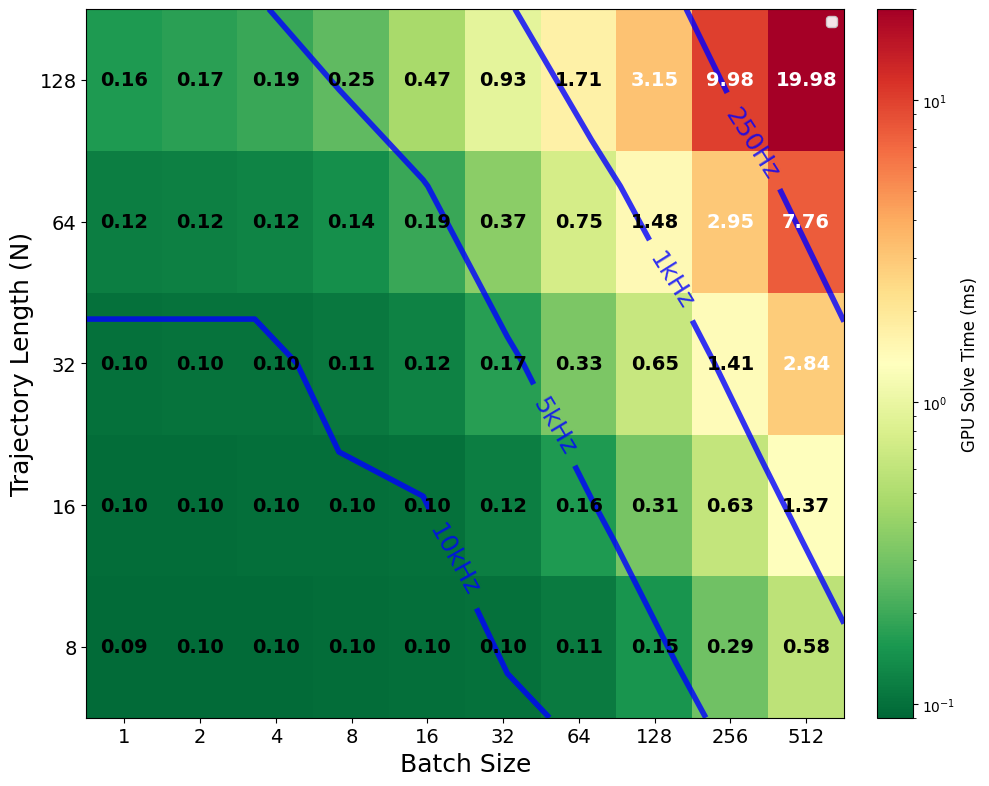


Figure saved as 'gato_solve_time_heatmap.png'


In [4]:
fig, ax = plt.subplots(figsize=(10, 8))

# Use logarithmic scale for better color variation
from matplotlib.colors import LogNorm

Z_time_ms = Z_time  # Already in milliseconds

vmin, vmax = 0.09, 20.0
im = ax.imshow(Z_time_ms, aspect='auto', origin='lower', 
               cmap='RdYlGn_r', norm=LogNorm(vmin=vmin, vmax=vmax),
               extent=[-0.5, len(batch_sizes)-0.5, -0.5, len(knot_points)-0.5],
               interpolation='nearest')

# Add text annotations for actual GPU solve times
for i in range(len(knot_points)):
    for j in range(len(batch_sizes)):
        if not np.isnan(Z_time_ms[i, j]):
            text_color = 'white' if Z_time_ms[i, j] > 2.0 else 'black'
            ax.text(j, i, f'{Z_time_ms[i, j]:.2f}', ha='center', va='center', 
                   color=text_color, fontsize=14, fontweight='bold')

# Round solve time values for contour plotting
Z_time_rounded = np.round(Z_time, 2)  # Round to 2 decimal places

# Add minimal contour lines for key control rates (using rounded values)
contour_levels = [0.105, 0.2, 1, 4]  # ~10kHz, 5kHz, 1kHz, 250Hz
CS = ax.contour(Z_time_rounded, levels=contour_levels, 
                colors=['blue'], linewidths=4, alpha=0.8,
                extent=[-0.5, len(batch_sizes)-0.5, -0.5, len(knot_points)-0.5])

# Create labels with both solve time and control rate
def format_contour_label(solve_time_ms):
    control_rate_khz = 1.0 / solve_time_ms
    
    if control_rate_khz >= 1:
        return f'{control_rate_khz:.0f}kHz'
    else:
        return f'{control_rate_khz * 1000:.0f}Hz'

ax.clabel(CS, inline=True, fontsize=18, fmt=format_contour_label, inline_spacing=10, 
          manual=[(4.0, 0.5), (5.5, 1.5), (7.0, 2.5), (9.5, 4.0)])

# Set ticks and labels
ax.set_xticks(range(len(batch_sizes)))
ax.set_xticklabels([str(b) for b in batch_sizes], fontsize=14)
ax.set_yticks(range(len(knot_points)))
ax.set_yticklabels([str(n) for n in knot_points], fontsize=14)

# Labels and title
ax.set_xlabel('Batch Size', fontsize=18)
ax.set_ylabel('Trajectory Length (N)', fontsize=18)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('GPU Solve Time (ms)', fontsize=12)

ax.legend(loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('gato_solve_time_heatmap.png', dpi=150, bbox_inches='tight')
print("\nFigure saved as 'gato_solve_time_heatmap.png'")